In [1]:
import os
import tarfile
import shutil
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
from tqdm.notebook import tqdm
from transformers import CLIPProcessor, CLIPModel
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import re
import torch.nn.functional as F
from google.colab import files
from torch.cuda.amp import GradScaler

In [ ]:
from google.colab import files
uploaded = files.upload()

!gdown --folder https://drive.google.com/drive/folders/1ntmFAYessXYRLl8yuD_sPqdyPRtzxwyz
%cd /content/Classification
!tar -xf ip102_v1.1.tar

## BASE-FEATURES for model-base
!gdown --id 1XgYouWvmB7yAKXY-ITbK5XxofywrXaiv
!unzip -q features.zip

Saving classes.txt to classes.txt
Saving gemini2.txt to gemini2.txt
Saving gemini-short.txt to gemini-short.txt
Saving prompt_gemini.txt to prompt_gemini.txt
Saving prompt_gpt.txt to prompt_gpt.txt
Retrieving folder contents
Processing file 1EL9TA-J5XsiBR4M3nQkMR_e-2dP48eQN ip102_v1.1.tar
Processing file 1Xa3p1h8jkk7ECHzSuGYrn-d39QOd0ezj classes.txt
Processing file 1kCHN6JKuK-3cSG5jGQQLRX94fAzAeCwPFH-ZsHfs5Jw classes
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Failed to retrieve file url:

	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id

In [ ]:
!gdown --id 1EL9TA-J5XsiBR4M3nQkMR_e-2dP48eQN
!tar -xf ip102_v1.1.tar

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1EL9TA-J5XsiBR4M3nQkMR_e-2dP48eQN
From (redirected): https://drive.google.com/uc?id=1EL9TA-J5XsiBR4M3nQkMR_e-2dP48eQN&confirm=t&uuid=ddb5059f-ee5e-4eb9-a546-b57dc0f0ddb6
To: /content/Classification/ip102_v1.1.tar
100% 3.25G/3.25G [00:52<00:00, 62.1MB/s]


In [4]:
!gdown --folder https://drive.google.com/drive/folders/1ntmFAYessXYRLl8yuD_sPqdyPRtzxwyz?usp=sharing
%cd /content/Classification
!tar -xf ip102_v1.1.tar

Retrieving folder contents
Processing file 1EL9TA-J5XsiBR4M3nQkMR_e-2dP48eQN ip102_v1.1.tar
Processing file 1Xa3p1h8jkk7ECHzSuGYrn-d39QOd0ezj classes.txt
Processing file 1kCHN6JKuK-3cSG5jGQQLRX94fAzAeCwPFH-ZsHfs5Jw classes
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=1EL9TA-J5XsiBR4M3nQkMR_e-2dP48eQN
From (redirected): https://drive.google.com/uc?id=1EL9TA-J5XsiBR4M3nQkMR_e-2dP48eQN&confirm=t&uuid=45af6788-ee21-4928-a50a-ccd1878f081a
To: /content/Classification/ip102_v1.1.tar
100% 3.25G/3.25G [00:38<00:00, 83.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Xa3p1h8jkk7ECHzSuGYrn-d39QOd0ezj
To: /content/Classification/classes.txt
100% 2.82k/2.82k [00:00<00:00, 15.2MB/s]
Failed to retrieve file url:

	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses.
	Check FAQ in https

In [71]:
# features large

from google.colab import drive

!gdown --id 1pTVdggXT6jlu5qUdeC6cju021TGos4jG
!unzip -q precomputed_features_large.zip

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1pTVdggXT6jlu5qUdeC6cju021TGos4jG
From (redirected): https://drive.google.com/uc?id=1pTVdggXT6jlu5qUdeC6cju021TGos4jG&confirm=t&uuid=34f7024f-87e1-42a8-bbb2-9e1d78fc3c38
To: /content/precomputed_features_large.zip
100% 216M/216M [00:04<00:00, 45.4MB/s]


In [6]:
uploaded = files.upload()

Saving classes.txt to classes (1).txt
Saving gemini2.txt to gemini2.txt
Saving gemini-short.txt to gemini-short.txt
Saving prompt_gemini.txt to prompt_gemini.txt
Saving prompt_gpt.txt to prompt_gpt.txt


# SoftPrompt Class & feature train/val

In [ ]:
class SoftPrompt(nn.Module):
    def __init__(self, num_classes, prompt_length, embed_dim, class_prompts, tokenizer, text_model, text_projection):
        super().__init__()
        self.num_classes = num_classes
        self.prompt_length = prompt_length
        self.embed_dim = embed_dim
        self.tokenizer = tokenizer
        self.text_model = text_model
        self.text_projection = text_projection

        self.soft_prompts = nn.Parameter(torch.randn(num_classes, prompt_length, embed_dim) * 0.02)

        for param in self.text_model.parameters():
            param.requires_grad = False
        for param in self.text_projection.parameters():
            param.requires_grad = False

        text_inputs = self.tokenizer(
            class_prompts, 
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=77 - prompt_length
        )

        self.register_buffer('class_prompt_ids', text_inputs['input_ids'])

    def forward(self):
        device = self.soft_prompts.device

        token_embeds = self.text_model.embeddings.token_embedding(self.class_prompt_ids)

        combined_embeds = torch.cat([self.soft_prompts, token_embeds], dim=1)

        seq_len = combined_embeds.size(1)
        position_ids = torch.arange(seq_len, dtype=torch.long, device=device).unsqueeze(0) 
        position_embeds = self.text_model.embeddings.position_embedding(position_ids)

        inputs_embeds = combined_embeds + position_embeds

        encoder_outputs = self.text_model.encoder(
            inputs_embeds=inputs_embeds
        )
        last_hidden_state = encoder_outputs.last_hidden_state 

        last_hidden_state = self.text_model.final_layer_norm(last_hidden_state)

        eos_token_indices = self.class_prompt_ids.argmax(dim=-1) + self.prompt_length

        pooled_output = last_hidden_state[torch.arange(self.num_classes, device=device), eos_token_indices]

        text_features = self.text_projection(pooled_output)

        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

        return text_features 

In [47]:
def train_on_features(model, soft_prompt, train_feature_loader, val_feature_loader, epochs=20, lr=1e-3, class_weights= None):
    device = next(soft_prompt.parameters()).device

    optimizer = optim.AdamW(soft_prompt.parameters(), lr=lr, weight_decay=0.01)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    scaler = GradScaler()

    print("\n🔁 Start Training on Features!!!!...")
    best_val_acc = 0.0
    patience = 5
    patience_counter = 0

    for epoch in range(epochs):
        soft_prompt.train()
        total_loss = 0
        correct = 0
        total = 0

        for image_features, labels in tqdm(train_feature_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            image_features = image_features.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.amp.autocast(device_type='cuda'):
                text_features = soft_prompt()
                logit_scale = model.logit_scale.exp()
                similarities = torch.matmul(image_features, text_features.T) * logit_scale
                loss = criterion(similarities, labels)

            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(soft_prompt.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()
            preds = similarities.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        avg_loss = total_loss / len(train_feature_loader)

        val_acc = evaluate_on_features(model, soft_prompt, val_feature_loader, device)

        scheduler.step()

        print(f"\n📉 Epoch {epoch+1}: Train Loss: {avg_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(soft_prompt.state_dict(), 'best_soft_prompt_on_features.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"EARLY Stopping in Epoch {epoch+1}")
                break

    print("\n✅ Train Completed!")
    soft_prompt.load_state_dict(torch.load('best_soft_prompt_on_features.pth'))
    return soft_prompt

In [ ]:
def evaluate_on_features(model, soft_prompt, feature_loader, device):
    soft_prompt.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        with torch.amp.autocast(device_type='cuda'):
            text_features = soft_prompt()

        for image_features, labels in tqdm(feature_loader, desc="Evaluating"):
            image_features = image_features.to(device)
            labels = labels.to(device)

            with torch.amp.autocast(device_type='cuda'): 
                logit_scale = model.logit_scale.exp()
                similarities = torch.matmul(image_features, text_features.T) * logit_scale

            preds = similarities.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return correct / total

In [51]:
import torch
import torch.nn as nn
import numpy as np

def calculate_class_weights(labels_np):
    class_counts = np.bincount(labels_np)
    total_samples = len(labels_np)
    num_classes = len(class_counts)

    class_weights = total_samples / (num_classes * class_counts + 1e-6)
    return torch.tensor(class_weights, dtype=torch.float)

# train_labels_numpy = train_feature_dataset.labels.numpy()
# class_weights = calculate_class_weights(train_labels_numpy).to(device)

# Functions

In [2]:
# ----------------------------------------------------
def mount_drive():
    """Mount Google Drive into Colab"""
    drive.mount('/content/drive')
    print("✅ Google Drive mounted.")

# ----------------------------------------------------
def extract_dataset(tar_path, extract_to='./'):
    """Extracts a .tar file if the destination folder doesn't already exist"""
    dataset_folder = os.path.join(extract_to, 'ip102_v1.1')

    if not os.path.exists(dataset_folder):
        print("📦 Extracting dataset...")
        with tarfile.open(tar_path, 'r') as tar:
            tar.extractall(path=extract_to)
        print("✅ Dataset extracted to:", dataset_folder)
    else:
        print("✅ Dataset already extracted. Skipping.")

# ----------------------------------------------------
def copy_classes_file(src_path, dst_path='./classes.txt'):
    """Copies classes.txt if not already present"""
    if not os.path.exists(dst_path):
        shutil.copy(src_path, dst_path)
        print("✅ classes.txt copied to current directory.")
    else:
        print("✅ classes.txt already exists. Skipping copy.")

# ----------------------------------------------------
def copy_prompts_file(src_path, dst_path):
    """Copies classes.txt if not already present"""
    if not os.path.exists(dst_path):
        shutil.copy(src_path, dst_path)
        print("✅ classes.txt copied to current directory.")
    else:
        print("✅ classes.txt already exists. Skipping copy.")

In [3]:
from google.colab import drive
mount_drive()
tar_path = '/content/drive/MyDrive/PEST-DS/ip102_v1.1.tar'


extract_dataset(tar_path)

MessageError: Error: credential propagation was unsuccessful

In [3]:
class Constants:
    ## PATHs ##
    DATASET_ROOT = './Classification/ip102_v1.1/'
    IMG_ROOT = os.path.join(DATASET_ROOT, "images")
    TRAIN_PATH = os.path.join(DATASET_ROOT, "train.txt")
    VAL_PATH = os.path.join(DATASET_ROOT, "val.txt")
    TEST_PATH = os.path.join(DATASET_ROOT, "test.txt")
    ID_CLASSES_PATH = os.path.join('./', "classes.txt")
    PROMPT_GEMINI = os.path.join('./', "prompt_gemini.txt")
    PROMPT_GEMINI_2 = os.path.join('./', "prompt_gemini2.txt")
    PROMPT_GEMINI_SHORT = os.path.join('./', "gemini-short.txt")
    PROMPT_GPT = os.path.join('./', "prompt_gpt.txt")
    PROMPT_MOAH = os.path.join('./', "simple prompt.txt")
    BATCH_SIZE = 64
    SHUFFLE = True

In [ ]:
def load_split_file(file_path):
    with open(file_path, 'r') as f:
        samples = np.array(
            [(path, int(label)) for path, label in (line.strip().split() for line in f)],
            dtype=object
        )
    return samples

def load_txt_file(file_path):
    with open(file_path, 'r') as f:
      lines = f.readlines()
    return lines

def load_classes(filepath):
    with open(filepath, 'r') as f:
        lines = f.readlines()
    classes = []
    ids = []
    for line in lines:
        parts = line.strip().split(maxsplit=1)
        if len(parts) == 2:
            id_str, label = parts
            id = int(id_str)
            ids.append(id)
            classes.append(label)
    return ids, classes

In [5]:
class CustomImageDataset(Dataset):
    def __init__(self, image2class_path, transform=None):
        self.data_list = load_split_file(image2class_path)
        self.root_dir = Constants.IMG_ROOT
        self.transform = transform

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        path, label = self.data_list[idx]
        image_path = os.path.join(self.root_dir, path)
        image = Image.open(image_path).convert('RGB')  # Ensure RGB format

        if self.transform:
            image = self.transform(image)
        return image, label

In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_dataset = CustomImageDataset(Constants.TRAIN_PATH, transform=transform)
val_dataset = CustomImageDataset(Constants.VAL_PATH, transform=transform)
test_dataset = CustomImageDataset(Constants.TEST_PATH, transform=transform)

In [7]:
train_loader = DataLoader(train_dataset, batch_size=Constants.BATCH_SIZE, shuffle=Constants.SHUFFLE)
val_loader = DataLoader(val_dataset, batch_size=Constants.BATCH_SIZE, shuffle=Constants.SHUFFLE)
test_loader = DataLoader(test_dataset, batch_size=Constants.BATCH_SIZE, shuffle=Constants.SHUFFLE)

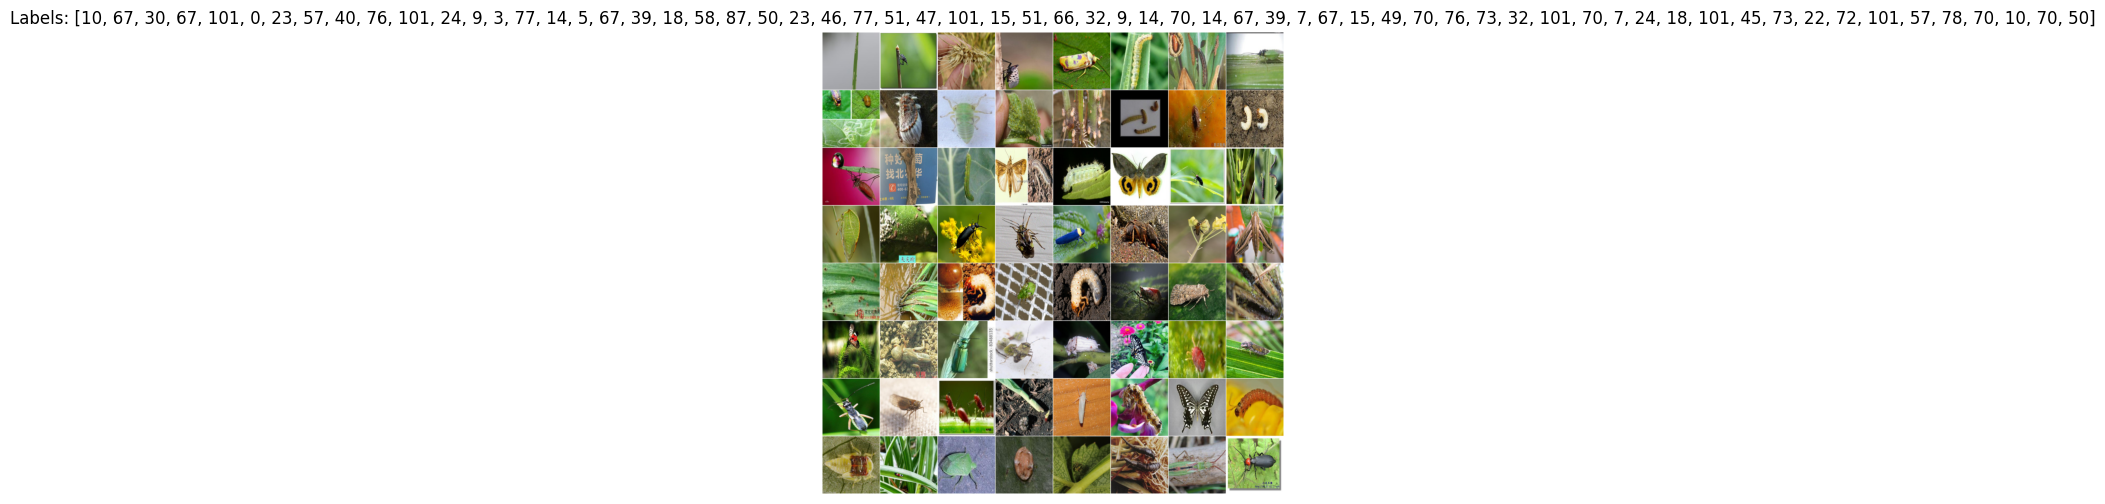

In [ ]:
images, labels = next(iter(train_loader))

grid = make_grid(images, nrow=8, normalize=True, pad_value=1)

npimg = grid.permute(1, 2, 0).numpy()

plt.figure(figsize=(12, 6))
plt.imshow(npimg)
plt.title(f"Labels: {labels.tolist()}")
plt.axis("off")
plt.show()

In [9]:
def load_prompt_gpt(file_path):
    with open(file_path, 'r') as f:
        content = f.read()

    entries = re.split(r'\n(?=\*\*\d+\.\s)', content)
    prompts = []

    for entry in entries:
        match = re.match(r'\*\*(\d+)\.\s(.*?)\*\*\n(.*)', entry.strip(), re.DOTALL)
        if match:
            class_id, title, description = match.groups()
            full_prompt = f"{title}. {description.strip()}"
            prompts.append(full_prompt)
        else:
            print(f"⚠️ Couldn't parse entry:\n{entry[:100]}")

    assert len(prompts) == 102, f"Expected 102 prompts, got {len(prompts)}"
    return prompts

In [10]:
def load_prompt_gemini(file_path):
    with open(file_path, 'r') as f:
        content = f.read()

    entries = re.split(r'\n(?=###\s\d+\.\s)', content.strip())
    prompts = []

    for entry in entries:
        lines = entry.strip().split('\n')
        if not lines or not lines[0].startswith('###'):
            continue

        title_match = re.match(r'###\s*(\d+)\.\s+(.*)', lines[0])
        if not title_match:
            print(f"⚠️ Couldn't parse entry title:\n{lines[0]}")
            continue
        number, title = title_match.groups()

        body = '\n'.join(lines[1:]).strip()

        bold_match = re.match(r'\*\*(.*?)\*\*\s*[,:\-–—]?\s*(.*)', body, re.DOTALL)
        if bold_match:
            bold_title, description = bold_match.groups()
            full_title = bold_title.strip()
        else:
            full_title = title.strip()
            description = body.strip()

        prompt = f"{full_title}. {description}"
        prompts.append(prompt)

    assert len(prompts) == 102, f"Expected 102 prompts, got {len(prompts)}"
    return prompts

In [11]:
def load_prompt_gemini2(file_path):
    with open(file_path, 'r') as f:
        content = f.read()

    entries = re.split(r'\n(?=\d+\.\s)', content.strip())
    return [e.strip() for e in entries if e.strip()]

In [12]:
def load_prompt_gemini_short(file_path):
    with open(file_path, 'r') as f:
        content = f.read()
    lines = content.strip().splitlines()
    entries = [line.strip() for line in lines if line.strip()]
    return entries

In [19]:
ids, classes = load_classes(Constants.ID_CLASSES_PATH)

In [53]:
prompt_gemini = load_prompt_gemini(Constants.PROMPT_GEMINI)
prompt_gemini_short = load_prompt_gemini_short(Constants.PROMPT_GEMINI_SHORT)
prompt_gpt = load_prompt_gpt(Constants.PROMPT_GPT)
classic_prompts = [f"a photo of {class_name}" for class_name in classes]

In [21]:
# Validation function
def evaluate_model(data_loader, text_features, model, processor, device):
    model.eval()
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(tqdm(data_loader, desc="Evaluating")):
            # Convert tensor images back to PIL for processor
            if isinstance(images, torch.Tensor):
                images_pil = []
                for img_tensor in images:
                    # Convert tensor to PIL
                    img_pil = transforms.ToPILImage()(img_tensor)
                    images_pil.append(img_pil)
                images = images_pil

            labels = labels.to(device)

            # Process images
            image_inputs = processor(images=images, return_tensors="pt", padding=True)
            image_inputs = {k: v.to(device) for k, v in image_inputs.items()}

            # Get image features
            image_features = model.get_image_features(**image_inputs)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)  # Normalize

            # Compute similarities (cosine similarity)
            similarities = torch.matmul(image_features, text_features.T)

            # Get predictions
            predictions = torch.argmax(similarities, dim=1)

            correct += (predictions == labels).sum().item()
            total += labels.size(0)

            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = correct / total
    return accuracy, all_predictions, all_labels

In [ ]:
# SETTINGS
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Use CLIP model which is better for zero-shot classification
model_name = "openai/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(model_name).to(device)
processor = CLIPProcessor.from_pretrained(model_name)
model.eval()

print(f"Loaded model: {model_name}")
print(f"Number of classes: {len(classes)}")

# Create class prompts for better classification
class_prompts = classic_prompts
print("Computing class embeddings...")
# Compute text embeddings for all classes
with torch.no_grad():
    text_inputs = processor(text=class_prompts, return_tensors="pt", padding=True, truncation=True)
    text_inputs = {k: v.to(device) for k, v in text_inputs.items()}
    text_features = model.get_text_features(**text_inputs)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)  # Normalize

print(f"Text features shape: {text_features.shape}")


# Run validation
print("Starting validation...")
val_accuracy, val_preds, val_labels = evaluate_model(val_loader, text_features, model, processor, device)

# Run test
print("Starting Testing...")
test_accuracy, test_preds, test_labels = evaluate_model(test_loader, text_features, model, processor, device)

print(f"✅ Validation Accuracy: {val_accuracy:.4f}")
print(f"✅ Test Accuracy: {test_accuracy:.4f}")

Using device: cuda
Loaded model: openai/clip-vit-base-patch32
Number of classes: 102
Computing class embeddings...
Text features shape: torch.Size([102, 512])
Starting validation...


Evaluating:   0%|          | 0/470 [00:00<?, ?it/s]

Starting Testing...


Evaluating:   0%|          | 0/1414 [00:00<?, ?it/s]

✅ Validation Accuracy: 0.1368
✅ Test Accuracy: 0.1311


In [ ]:
# # Optional: Show some classification results
# print("\nSample predictions:")
# for i in range(min(10, len(val_preds))):
#     print(val_preds[i])
#     pred_class = classes[val_preds[i]] if val_preds[i] < len(classes) else "Unknown"
#     true_class = classes[val_labels[i]] if val_labels[i] < len(classes) else "Unknown"
#     print(f"Predicted: {pred_class}, True: {true_class}")

# SOFT-PROMPT TUNING

## PREPARE DATA

In [32]:
from torch.utils.data import Dataset
import glob

class PrecomputedFeatureDataset(Dataset):
    def __init__(self, features_dir):
        self.feature_files = sorted(glob.glob(os.path.join(features_dir, "*.pt")))
        self.data_batches = [torch.load(f) for f in self.feature_files]
        self.features = torch.cat([b['features'] for b in self.data_batches])
        self.labels = torch.cat([b['labels'] for b in self.data_batches])

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [33]:
train_feature_dataset = PrecomputedFeatureDataset("./precomputed_features/train")
train_feature_loader = DataLoader(train_feature_dataset, batch_size=Constants.BATCH_SIZE, shuffle=True,num_workers=2, pin_memory=True)


v
train_feature_dataset = PrecomputedFeatureDataset("./precomputed_features/train")
train_feature_loader = DataLoader(train_feature_dataset, batch_size=Constants.BATCH_SIZE, shuffle=True,num_workers=2, pin_memory=True)


val_feature_dataset = PrecomputedFeatureDataset("./precomputed_features/val")
val_feature_loader = DataLoader(val_feature_dataset, batch_size=Constants.BATCH_SIZE, shuffle=True,num_workers=2, pin_memory=True)


test_feature_dataset = PrecomputedFeatureDataset("./precomputed_featur
MAal_feature_dataset = PrecomputedFeatureDataset("./precomputed_features/val")
val_feature_loader = DataLoader(val_feature_dataset, batch_size=Constants.BATCH_SIZE, shuffle=True,num_workers=2, pin_memory=True)


test_feature_dataset = PrecomputedFeatureDataset("./precomputed_features/test")
test_feature_loader = DataLoader(test_feature_dataset, batch_size=Constants.BATCH_SIZE, shuffle=True,num_workers=2, pin_memory=True)

# MODEL LARGE

In [72]:
train_feature_large_dataset = PrecomputedFeatureDataset("./precomputed_features_large/train")
train_feature_large_loader = DataLoader(train_feature_large_dataset, batch_size=Constants.BATCH_SIZE, shuffle=True,num_workers=2, pin_memory=True)


val_feature_large_dataset = PrecomputedFeatureDataset("./precomputed_features_large/val")
val_feature_large_loader = DataLoader(val_feature_large_dataset, batch_size=Constants.BATCH_SIZE, shuffle=True,num_workers=2, pin_memory=True)


test_feature_large_dataset = PrecomputedFeatureDataset("./precomputed_features_large/test")
test_feature_large_loader = DataLoader(test_feature_large_dataset, batch_size=Constants.BATCH_SIZE, shuffle=True,num_workers=2, pin_memory=True)

In [57]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model_name_large = "openai/clip-vit-large-patch14"
print(f"{model_name_large}")
model_large = CLIPModel.from_pretrained(model_name_large).to(device)
processor_large = CLIPProcessor.from_pretrained(model_name_large)

Using device: cuda
openai/clip-vit-large-patch14


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [ ]:
class_prompts = prompt_gpt

soft_prompt_large = SoftPrompt(
    num_classes=len(class_prompts),
    prompt_length=30,
    embed_dim=model_large.config.text_config.hidden_size,
    class_prompts=class_prompts,
    tokenizer=processor_large.tokenizer,
    text_model=model_large.text_model,
    text_projection=model_large.text_projection
).to(device)


trained_soft_prompt_large_first = train_on_features(
    model=model_large,
    soft_prompt=soft_prompt_large,
    train_feature_loader= train_feature_large_loader,
    val_feature_loader=val_feature_large_loader,
    epochs=15,
    lr=1e-2,
    class_weights= None
)

print("\n🧪 شروع ارزیابی نهایی روی داده‌های تست...")
test_acc = evaluate_on_features(
    model=model_large,
    soft_prompt=trained_soft_prompt_large_first,
    feature_loader=test_feature_large_loader,
    device=device
)
print(f"\n🎯 دقت نهایی روی داده‌های تست: {test_acc:.4f}")


🔁 Start Training on Features!!!!...


/tmp/ipython-input-44-2092365485.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Epoch 1/15:   0%|          | 0/705 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/118 [00:00<?, ?it/s]


📉 Epoch 1: Train Loss: 1.9162, Train Acc: 0.5521, Val Acc: 0.6082


Epoch 2/15:   0%|          | 0/705 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/118 [00:00<?, ?it/s]


📉 Epoch 2: Train Loss: 1.2803, Train Acc: 0.6434, Val Acc: 0.6359


Epoch 3/15:   0%|          | 0/705 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/118 [00:00<?, ?it/s]


📉 Epoch 3: Train Loss: 1.1722, Train Acc: 0.6664, Val Acc: 0.6327


Epoch 4/15:   0%|          | 0/705 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/118 [00:00<?, ?it/s]


📉 Epoch 4: Train Loss: 1.1066, Train Acc: 0.6836, Val Acc: 0.6444


Epoch 5/15:   0%|          | 0/705 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/118 [00:00<?, ?it/s]


📉 Epoch 5: Train Loss: 1.0545, Train Acc: 0.6970, Val Acc: 0.6442


Epoch 6/15:   0%|          | 0/705 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/118 [00:00<?, ?it/s]


📉 Epoch 6: Train Loss: 1.0092, Train Acc: 0.7061, Val Acc: 0.6526


Epoch 7/15:   0%|          | 0/705 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/118 [00:00<?, ?it/s]


📉 Epoch 7: Train Loss: 0.9666, Train Acc: 0.7187, Val Acc: 0.6605


Epoch 8/15:   0%|          | 0/705 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/118 [00:00<?, ?it/s]


📉 Epoch 8: Train Loss: 0.9216, Train Acc: 0.7302, Val Acc: 0.6628


Epoch 9/15:   0%|          | 0/705 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/118 [00:00<?, ?it/s]


📉 Epoch 9: Train Loss: 0.8794, Train Acc: 0.7427, Val Acc: 0.6605


Epoch 10/15:   0%|          | 0/705 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/118 [00:00<?, ?it/s]


📉 Epoch 10: Train Loss: 0.8400, Train Acc: 0.7552, Val Acc: 0.6704


Epoch 11/15:   0%|          | 0/705 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/118 [00:00<?, ?it/s]


📉 Epoch 11: Train Loss: 0.8003, Train Acc: 0.7676, Val Acc: 0.6731


Epoch 12/15:   0%|          | 0/705 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/118 [00:00<?, ?it/s]


📉 Epoch 12: Train Loss: 0.7640, Train Acc: 0.7803, Val Acc: 0.6751


Epoch 13/15:   0%|          | 0/705 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/118 [00:00<?, ?it/s]


📉 Epoch 13: Train Loss: 0.7323, Train Acc: 0.7920, Val Acc: 0.6846


Epoch 14/15:   0%|          | 0/705 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/118 [00:00<?, ?it/s]


📉 Epoch 14: Train Loss: 0.7084, Train Acc: 0.8013, Val Acc: 0.6826


Epoch 15/15:   0%|          | 0/705 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/118 [00:00<?, ?it/s]


📉 Epoch 15: Train Loss: 0.6931, Train Acc: 0.8061, Val Acc: 0.6845

✅ Train Completed!

🧪 شروع ارزیابی نهایی روی داده‌های تست...


Evaluating:   0%|          | 0/354 [00:00<?, ?it/s]


🎯 دقت نهایی روی داده‌های تست: 0.6828


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
trained_soft_prompt_large_second = train_on_features(
    model=model_large,
    soft_prompt= trained_soft_prompt_large_first,
    train_feature_loader= train_feature_large_loader,
    val_feature_loader=val_feature_large_loader,
    epochs=10,
    lr=1e-3,
    class_weights= class_weights
)

test_acc = evaluate_on_features(
    model=model_large,
    soft_prompt=trained_soft_prompt_large_first,
    feature_loader=test_feature_large_loader,
    device=device
)
print(f"\n🎯 final test acc: {test_acc:.4f}")


🔁 Start Training on Features!!!!...


/tmp/ipython-input-44-2092365485.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Epoch 1/10:   0%|          | 0/705 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/118 [00:00<?, ?it/s]


📉 Epoch 1: Train Loss: 0.7545, Train Acc: 0.7599, Val Acc: 0.6417


Epoch 2/10:   0%|          | 0/705 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/118 [00:00<?, ?it/s]


📉 Epoch 2: Train Loss: 0.7365, Train Acc: 0.7605, Val Acc: 0.6508


Epoch 3/10:   0%|          | 0/705 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/118 [00:00<?, ?it/s]


📉 Epoch 3: Train Loss: 0.7249, Train Acc: 0.7627, Val Acc: 0.6489


Epoch 4/10:   0%|          | 0/705 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/118 [00:00<?, ?it/s]


📉 Epoch 4: Train Loss: 0.7129, Train Acc: 0.7656, Val Acc: 0.6404


Epoch 5/10:   0%|          | 0/705 [00:00<?, ?it/s]

In [30]:
import os

# یک مسیر مشخص در گوگل درایو خود انتخاب کنید
GDRIVE_SAVE_PATH = "/content/drive/MyDrive/MyProject/trained_soft_prompt_large3.pth"
GDRIVE_FOLDER = "/content/drive/MyDrive/MyProject"

# اطمینان از وجود پوشه
os.makedirs(GDRIVE_FOLDER, exist_ok=True)

# ذخیره کردن state_dict
torch.save(trained_soft_prompt_large_first.state_dict(), GDRIVE_SAVE_PATH)


NameError: name 'trained_soft_prompt_large_first' is not defined

# DOWNLOAD learned LARGE MODEL

In [44]:
# DOWNLAOD LARGE MODEL PARAMETERS
!gdown --id 1LtQF_6bzK5rH7sLXWIKGxiZHr6bt7HDy -O trained_soft_prompt_large3.pth

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1LtQF_6bzK5rH7sLXWIKGxiZHr6bt7HDy
From (redirected): https://drive.google.com/uc?id=1LtQF_6bzK5rH7sLXWIKGxiZHr6bt7HDy&confirm=t&uuid=0e990c69-1b4e-4d82-8bcd-496bed24c8be
To: /content/trained_soft_prompt_large3.pth
100% 504M/504M [00:08<00:00, 56.1MB/s]


In [ ]:
class_prompts = prompt_gpt
downloaded_soft_prompts_large_model = SoftPrompt(
    num_classes=len(class_prompts),
    prompt_length=30,
    embed_dim= model_large.config.text_config.hidden_size,
    class_prompts=class_prompts,
    tokenizer=processor_large.tokenizer,
    text_model=model_large.text_model,
    text_projection=model_large.text_projection
).to(device)

In [70]:
state_dict = torch.load('./trained_soft_prompt_large3.pth', map_location=device)

downloaded_soft_prompts_large_model.load_state_dict(state_dict)

print("✅")

downloaded_soft_prompts_large_model.eval()

✅


SoftPrompt(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 768)
      (position_embedding): Embedding(77, 768)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05

# Question 4

In [41]:
import collections

def analyze_and_plot_distribution(dataset, dataset_name="Train"):
    print(f"در حال تحلیل توزیع برای مجموعه داده '{dataset_name}'...")

    if not hasattr(dataset, 'labels'):
        print("خطا: دیتاست ورودی باید دارای مشخصه 'labels' باشد.")
        return

    labels_tensor = dataset.labels
    labels_np = labels_tensor.numpy()

    class_counts = collections.Counter(labels_np)

    sorted_class_counts = sorted(class_counts.items())

    class_ids = [item[0] for item in sorted_class_counts]
    counts = [item[1] for item in sorted_class_counts]

    num_classes = len(class_ids)

    # print("-" * 50)
    # print(f"توزیع داده‌ها برای مجموعه داده '{dataset_name}' ({num_classes} کلاس):")
    # for class_id, count in sorted_class_counts:
    #     print(f"کلاس {class_id:3d}: {count:4d} نمونه")
    # print("-" * 50)

    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(20, 8))

    bars = ax.bar(class_ids, counts, color='skyblue', edgecolor='black')

    ax.set_title(f'{dataset_name}', fontsize=18, pad=20)
    ax.set_xlabel(' (Class ID)', fontsize=14, labelpad=15)
    ax.set_ylabel(' (Number of Samples)', fontsize=14, labelpad=15)

    ax.set_xticks(np.arange(min(class_ids), max(class_ids)+1, 5))
    ax.tick_params(axis='x', rotation=45, labelsize=10)
    ax.tick_params(axis='y', labelsize=10)

    plt.tight_layout()
    plt.show()

In [42]:
#ERROR? RUN PrepareData section if u have error!

در حال تحلیل توزیع برای مجموعه داده 'TRAIN'...


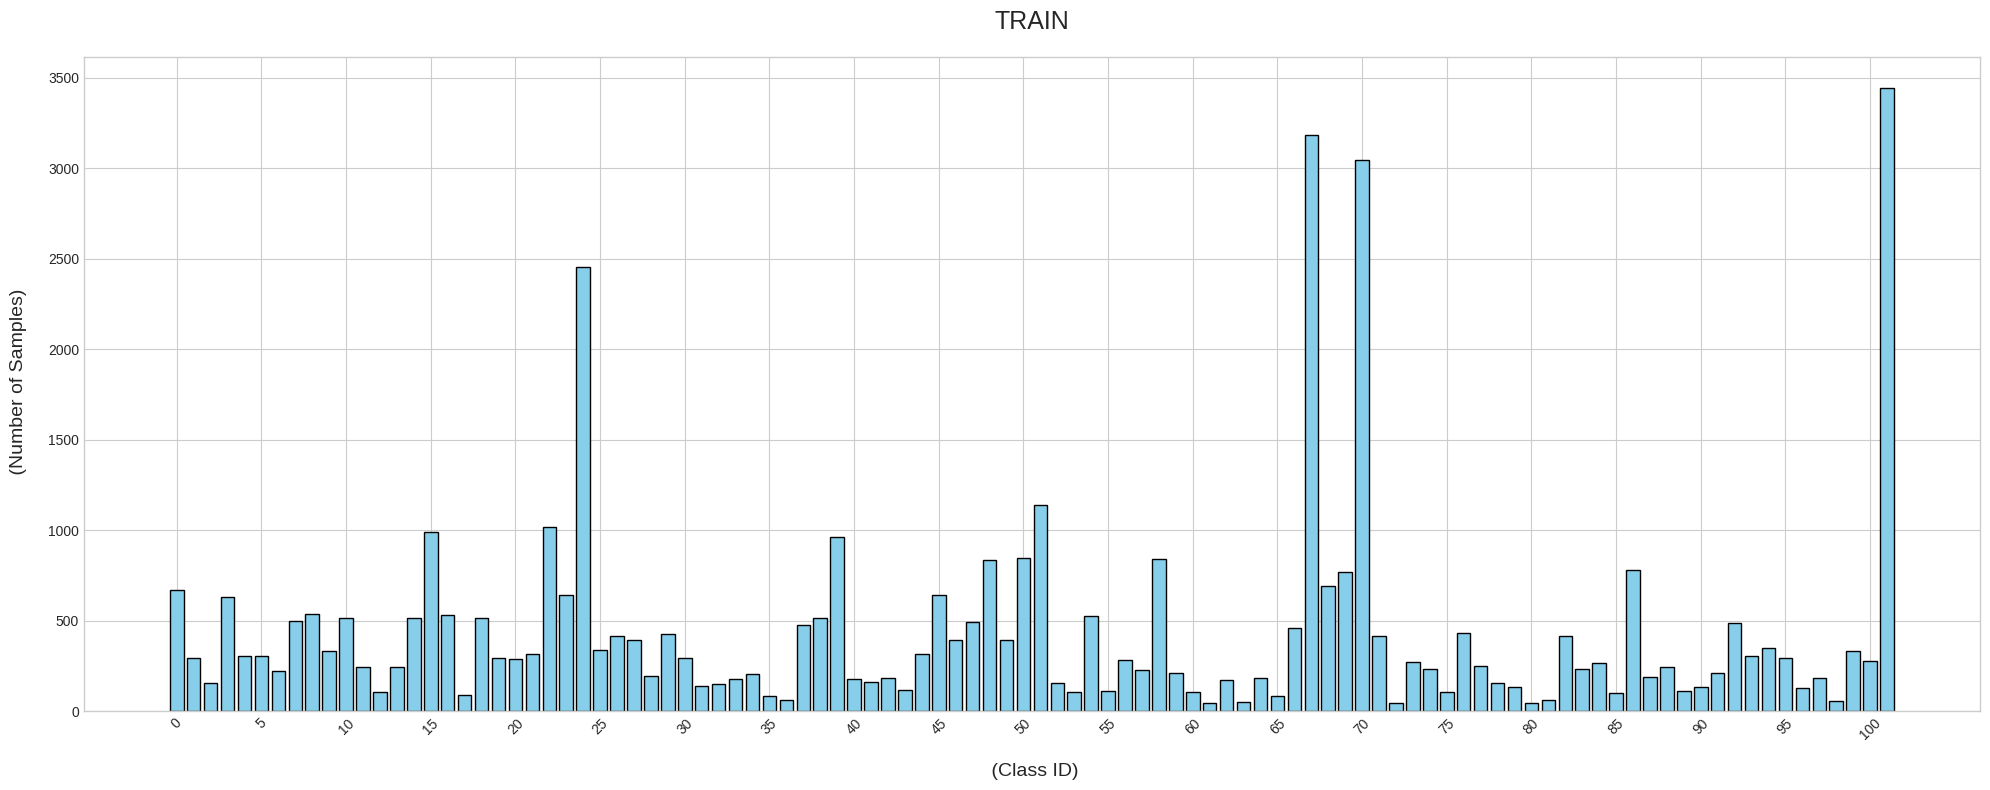

در حال تحلیل توزیع برای مجموعه داده 'VALIDATION'...


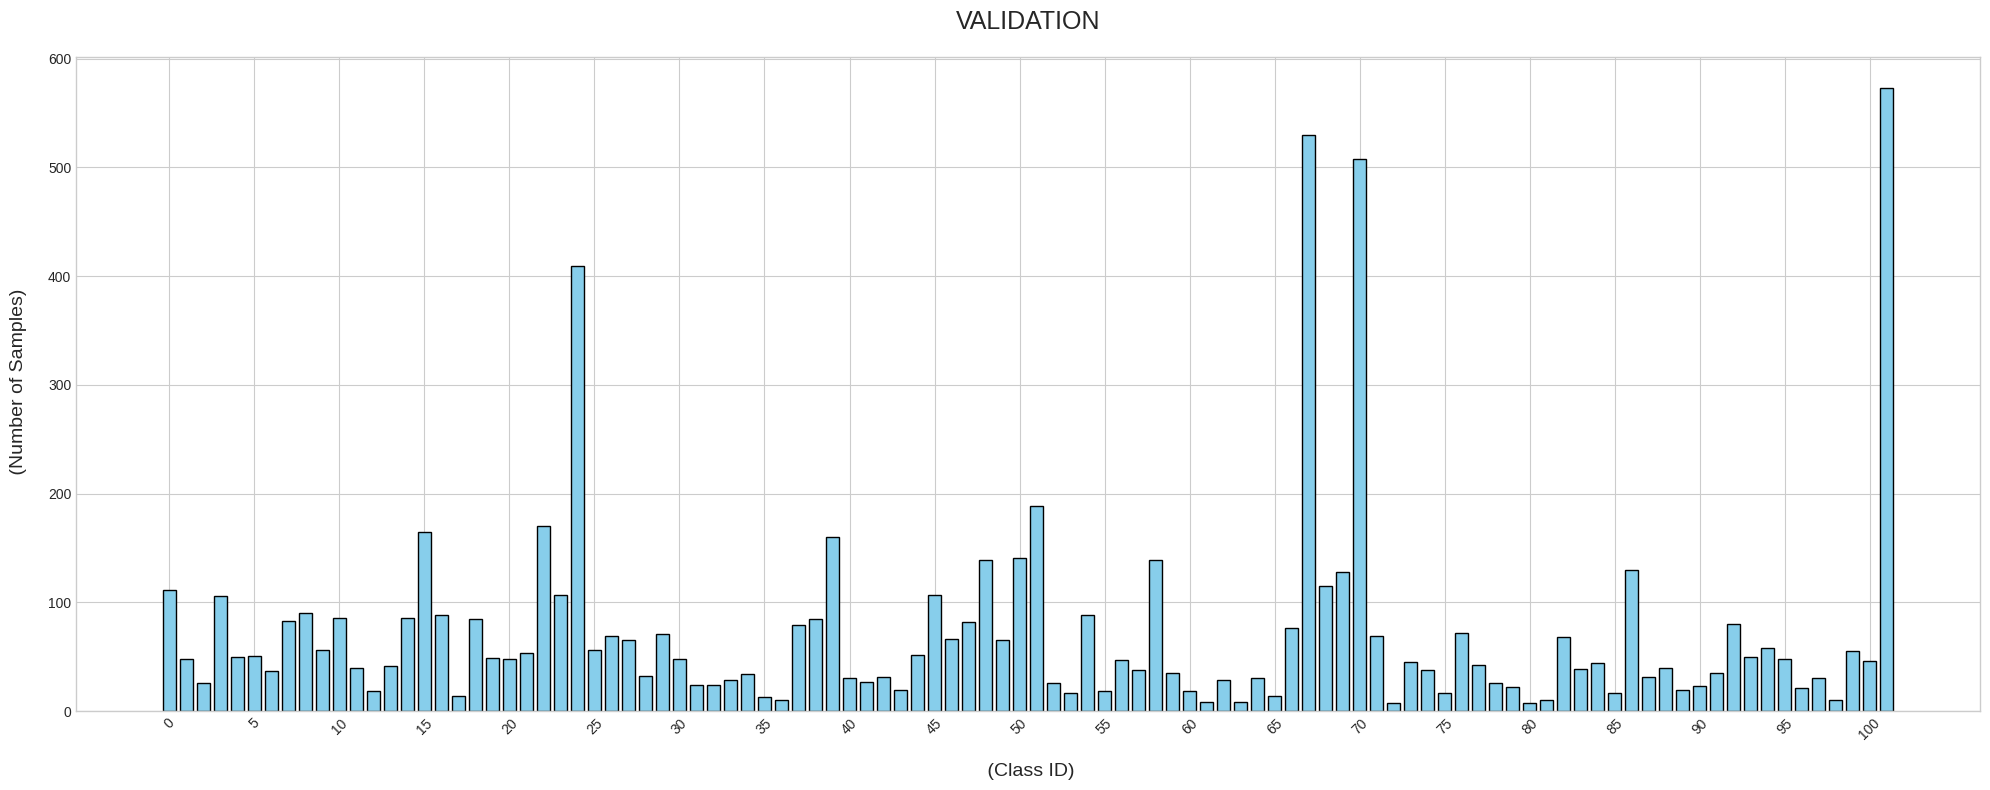

در حال تحلیل توزیع برای مجموعه داده 'TEST'...


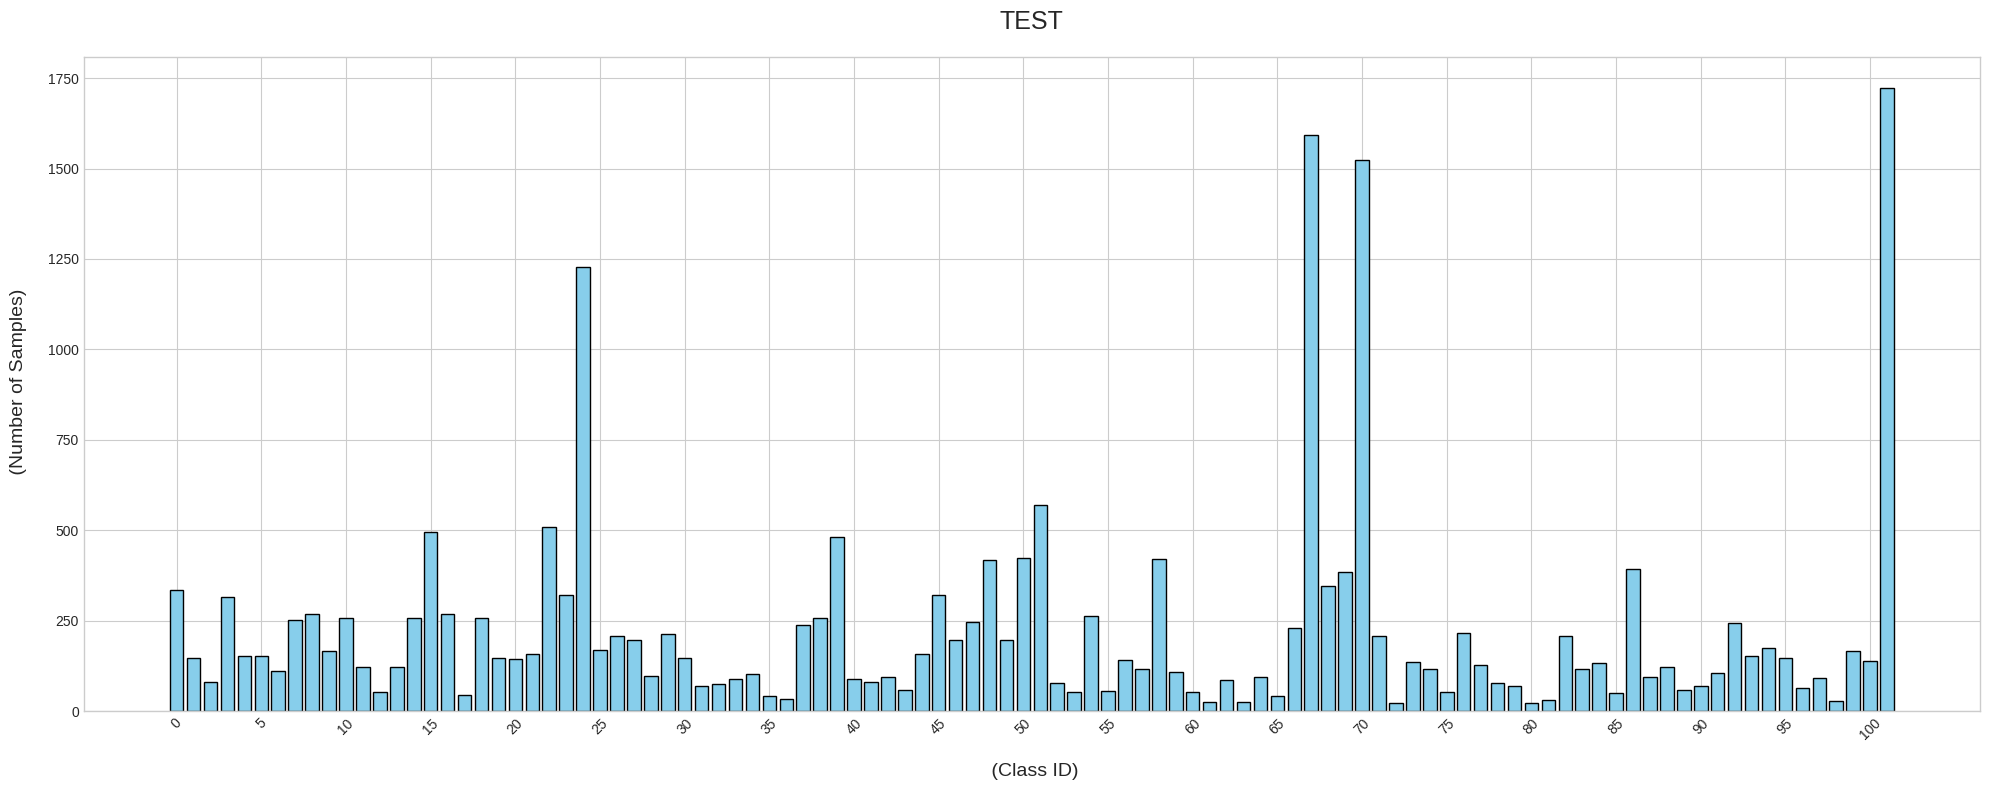

In [43]:
analyze_and_plot_distribution(train_feature_dataset, dataset_name="TRAIN")
analyze_and_plot_distribution(val_feature_dataset, dataset_name="VALIDATION")
analyze_and_plot_distribution(test_feature_dataset, dataset_name="TEST")

در حال اجرای پیش‌بینی روی مجموعه داده برای تحلیل خطا...


Predicting: 100%|██████████| 354/354 [00:01<00:00, 264.20it/s]



در حال ساخت ماتریس درهم‌ریختگی...


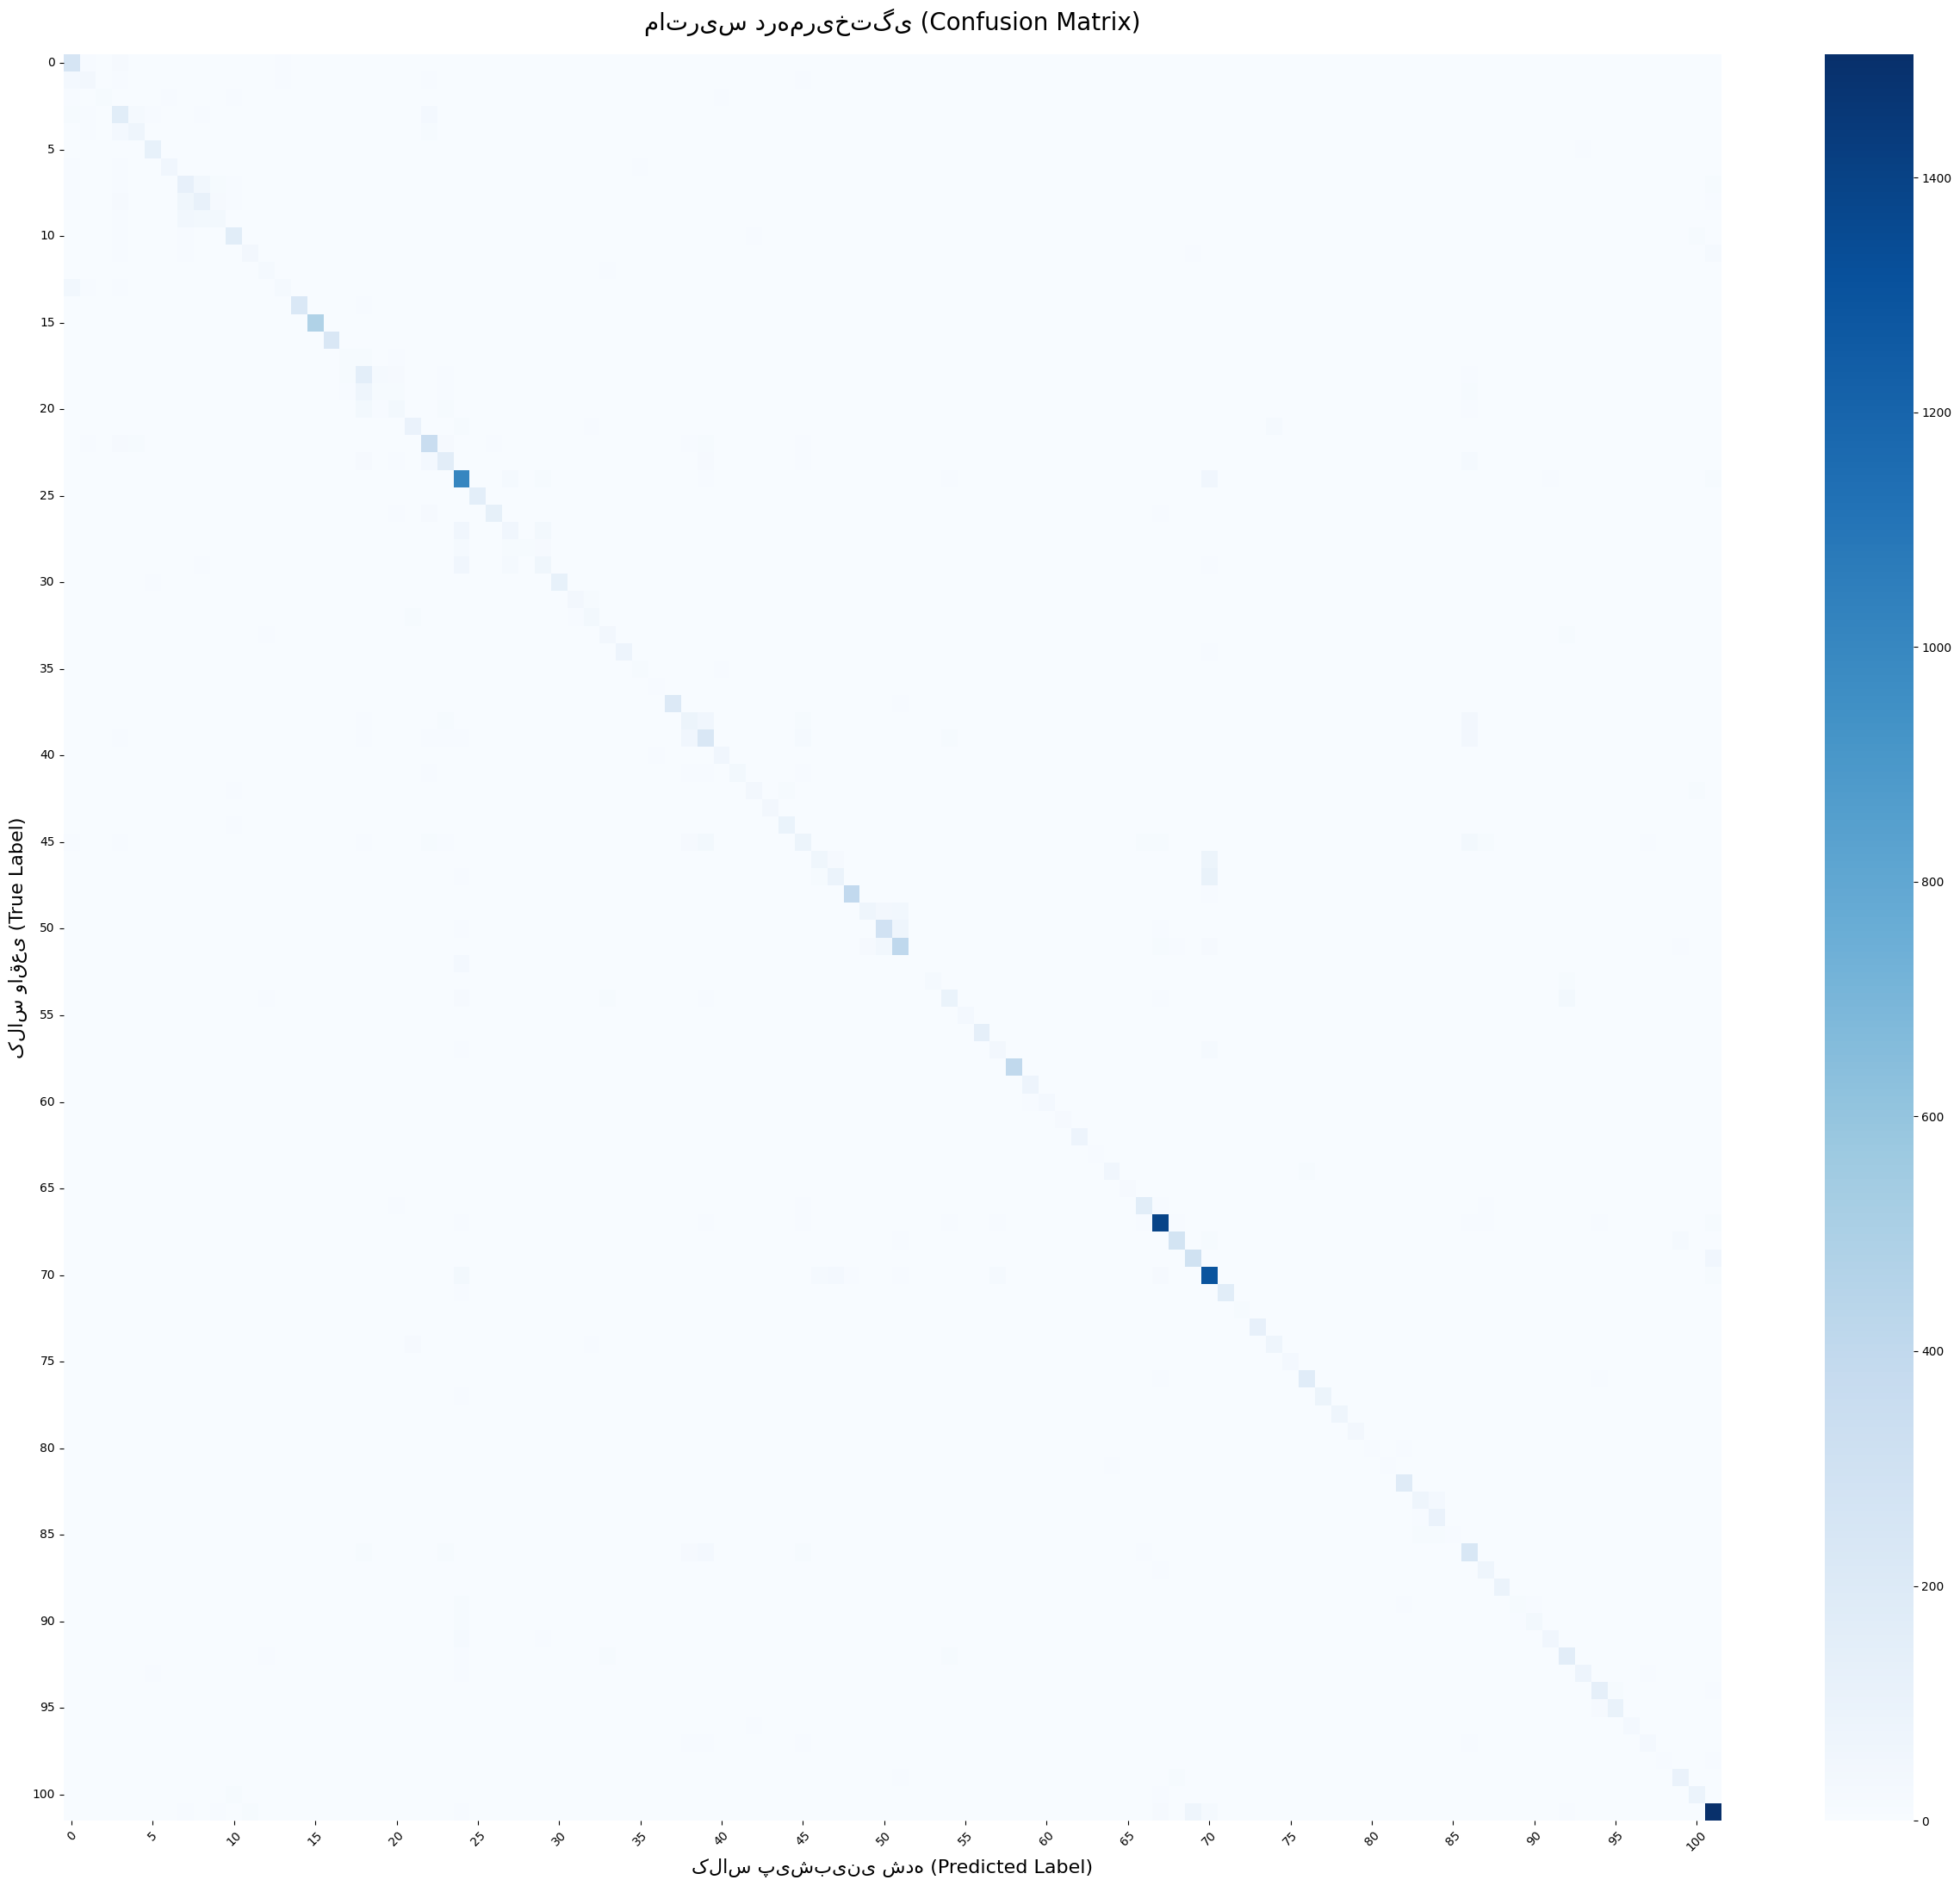


📊 تحلیل عملکرد کلاس‌ها (از بدترین به بهترین)
Class ID   | Accuracy     | Share in Dataset    
------------------------------------------------------------
52         |     5.13%      |   0.3448%
19         |     9.46%      |   0.6543%
28         |    17.35%      |   0.4333%
2          |    20.25%      |   0.3493%
13         |    20.33%      |   0.5438%
85         |    21.57%      |   0.2255%
89         |    22.81%      |   0.2520%
9          |    22.89%      |   0.7339%
45         |    26.56%      |   1.4147%
36         |    28.12%      |   0.1415%
29         |    28.17%      |   0.9417%
27         |    28.43%      |   0.8709%
20         |    28.47%      |   0.6366%
1          |    29.93%      |   0.6499%
46         |    30.96%      |   0.8709%
17         |    31.11%      |   0.1989%
98         |    32.14%      |   0.1238%
38         |    34.24%      |   1.1362%
63         |    34.62%      |   0.1149%
97         |    34.78%      |   0.4067%
81         |    36.67%      |   0.1326%
11  

In [ ]:
def analyze_model_errors(model, soft_prompt, data_loader, device, class_names):

    soft_prompt.eval()
    all_preds = []
    all_labels = []

    print("در حال اجرای پیش‌بینی روی مجموعه داده برای تحلیل خطا...")
    with torch.no_grad():
        with torch.amp.autocast(device_type='cuda'):
            text_features = soft_prompt()

        for image_features, labels in tqdm(data_loader, desc="Predicting"):
            image_features = image_features.to(device)

            with torch.amp.autocast(device_type='cuda'):
                logit_scale = model.logit_scale.exp()
                similarities = torch.matmul(image_features, text_features.T) * logit_scale

            preds = similarities.argmax(dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    num_classes = len(class_names)
    print("\nدر حال ساخت ماتریس درهم‌ریختگی...")
    cm = confusion_matrix(all_labels, all_preds, labels=range(num_classes))

    plt.style.use('default')
    fig, ax = plt.subplots(figsize=(25, 22))
    sns.heatmap(cm, annot=False, cmap='Blues', ax=ax, fmt='d')
    ax.set_title('ماتریس درهم‌ریختگی (Confusion Matrix)', fontsize=20, pad=20)
    ax.set_xlabel('کلاس پیش‌بینی شده (Predicted Label)', fontsize=16)
    ax.set_ylabel('کلاس واقعی (True Label)', fontsize=16)
    tick_interval = 5
    ax.set_xticks(np.arange(0, num_classes, tick_interval) + 0.5)
    ax.set_xticklabels(np.arange(0, num_classes, tick_interval), rotation=45)
    ax.set_yticks(np.arange(0, num_classes, tick_interval) + 0.5)
    ax.set_yticklabels(np.arange(0, num_classes, tick_interval), rotation=0)
    plt.tight_layout()
    plt.show()

    class_totals = cm.sum(axis=1)
    total_samples = class_totals.sum()

    per_class_accuracy = cm.diagonal() / np.maximum(class_totals, 1e-6)
    class_share = class_totals / total_samples

    sorted_indices = np.argsort(per_class_accuracy)

    print("\n" + "="*60)
    print("📊 تحلیل عملکرد کلاس‌ها (از بدترین به بهترین)")
    print("="*60)
    print(f"{'Class ID':<10} | {'Accuracy':<12} | {'Share in Dataset':<20}")
    print("-"*60)

    for class_idx in sorted_indices:
        accuracy = per_class_accuracy[class_idx]
        share = class_share[class_idx]
        print(f"{class_idx:<10} | {accuracy*100:8.2f}%      | {share*100:8.4f}%")

    return per_class_accuracy, class_share


per_class_acc, shares = analyze_model_errors(
    model= model_large,
    soft_prompt= downloaded_soft_prompts_large_model,
    data_loader= test_feature_large_loader,
    device=device,
    class_names=class_prompts
)


In [78]:
def display_sample_images(data_loader, class_ids_to_show, class_names, num_samples=5):
    sample_images = {class_id: [] for class_id in class_ids_to_show}
    found_counts = {class_id: 0 for class_id in class_ids_to_show}

    for images, labels in data_loader:
        for i in range(len(labels)):
            label = labels[i].item()
            if label in class_ids_to_show and found_counts[label] < num_samples:
                sample_images[label].append(images[i])
                found_counts[label] += 1

        if all(count >= num_samples for count in found_counts.values()):
            break


    num_classes_to_show = len(class_ids_to_show)
    fig, axes = plt.subplots(
        nrows=num_classes_to_show,
        ncols=num_samples,
        figsize=(num_samples * 3, num_classes_to_show * 3.5)
    )

    if num_classes_to_show == 1:
        axes = np.array([axes])

    for i, class_id in enumerate(class_ids_to_show):
        images_for_class = sample_images[class_id]

        row_title = f"CLASS {class_id}: {class_names[class_id].split('.')[0]}"
        axes[i, 0].set_ylabel(row_title, rotation=0, size='large', labelpad=80)

        for j in range(num_samples):
            ax = axes[i, j]
            if j < len(images_for_class):
                image_tensor = images_for_class[j]

                img_np = image_tensor.numpy().transpose((1, 2, 0))

                img_np = np.clip(img_np, 0, 1)

                ax.imshow(img_np)

            ax.set_xticks([])
            ax.set_yticks([])

    plt.tight_layout()
    plt.show()

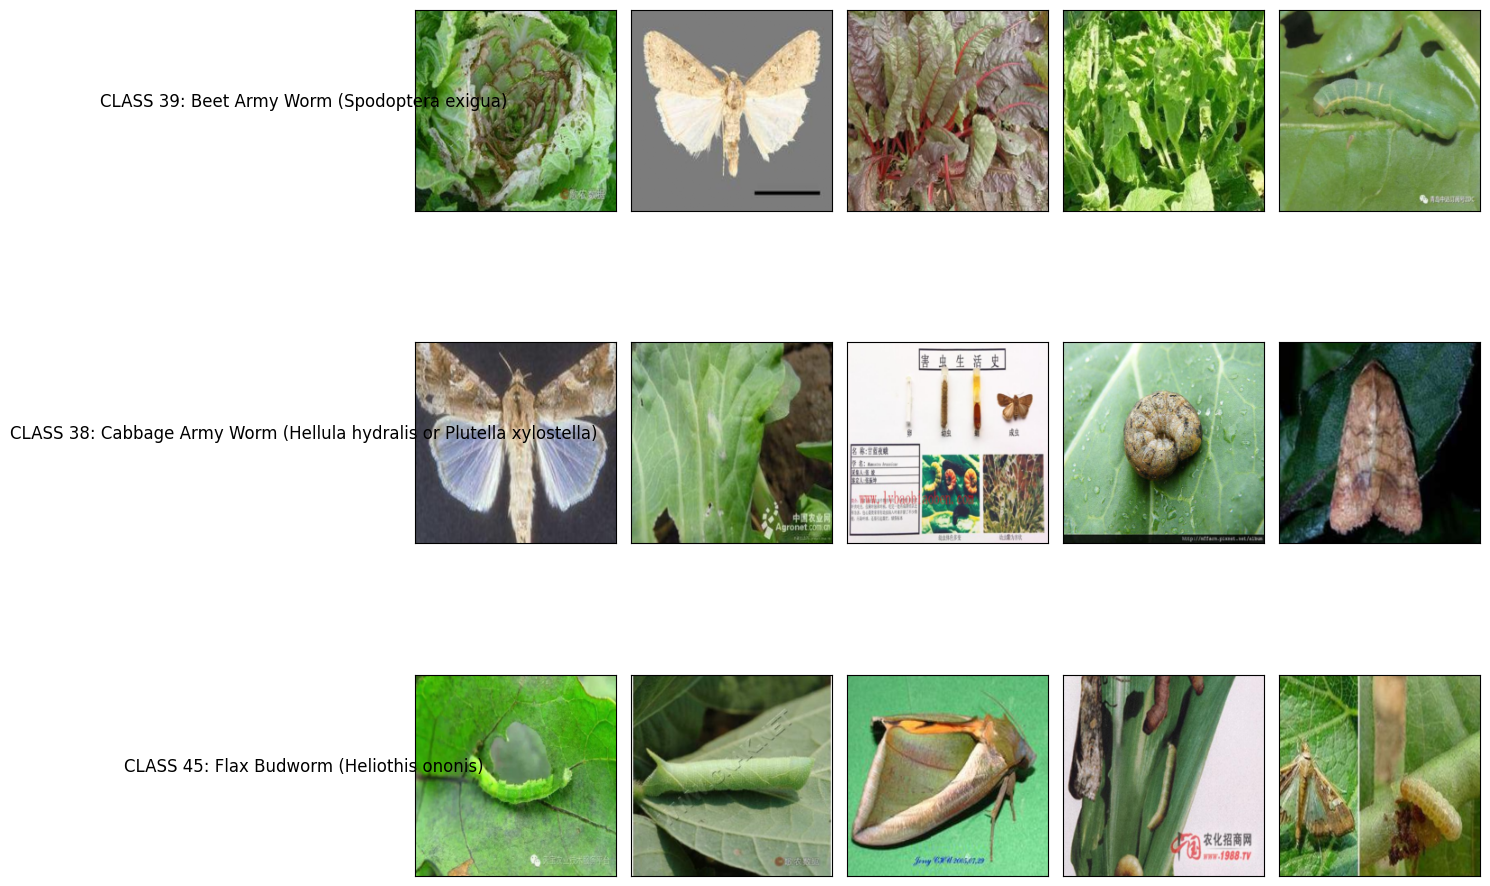

In [79]:
display_sample_images(
    data_loader=train_loader,
    class_ids_to_show=[39, 38, 45],
    class_names=class_prompts,
    num_samples=5
)

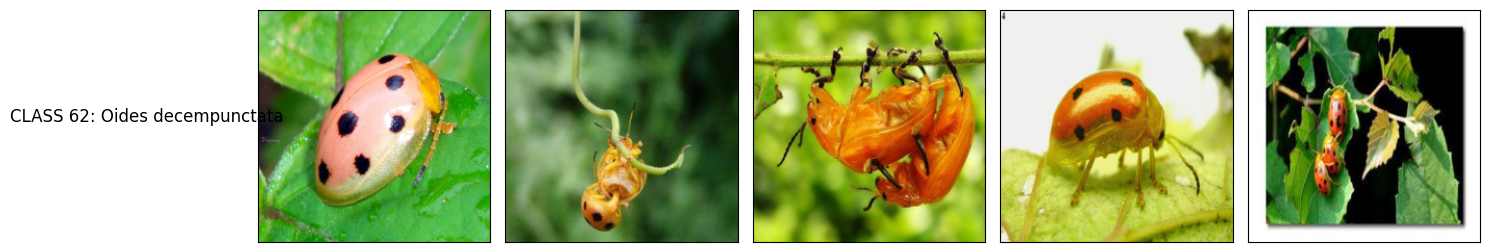

In [80]:
display_sample_images(
    data_loader=train_loader,
    class_ids_to_show=[62],
    class_names=class_prompts,
    num_samples=5
)

# SMOTE

In [ ]:
def create_boosted_dataset_with_smote(feature_dataset, min_samples_per_class=500):
    try:
        from imblearn.over_sampling import SMOTE
    except ImportError:
        import subprocess
        import sys
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "imbalanced-learn"])
        from imblearn.over_sampling import SMOTE

    X_original = feature_dataset.features.numpy()
    y_original = feature_dataset.labels.numpy()

    class_counts = collections.Counter(y_original)
    sampling_strategy = {}
    for class_id, count in class_counts.items():
        if count < min_samples_per_class:
            sampling_strategy[class_id] = min_samples_per_class
        else:
            sampling_strategy[class_id] = count

    print(f"\n{len([c for c in class_counts.values() if c < min_samples_per_class])} will be optimized")

    smote = SMOTE(random_state=42, sampling_strategy=sampling_strategy)

    print("\n working on SMOTE")
    X_resampled, y_resampled = smote.fit_resample(X_original, y_original)
    print("SMOTE applied Successfuly.")

    print(f"\n original data shape: {X_original.shape}")
    print(f"new data shape: {X_resampled.shape}")

    X_resampled_tensor = torch.tensor(X_resampled, dtype=torch.float)
    y_resampled_tensor = torch.tensor(y_resampled, dtype=torch.long)
    boosted_dataset = TensorDataset(X_resampled_tensor, y_resampled_tensor)

    return boosted_dataset

In [ ]:
boosted_train_dataset = create_boosted_dataset_with_smote(train_feature_dataset, min_samples_per_class=500)

boosted_train_loader = DataLoader(
    boosted_train_dataset,
    batch_size=256,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

# Save Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

GDRIVE_SAVE_PATH = "/content/drive/MyDrive/MyProject/trained_soft_prompt.pth"
GDRIVE_FOLDER = "/content/drive/MyDrive/MyProject"

os.makedirs(GDRIVE_FOLDER, exist_ok=True)

print(f"\n💾 در حال ذخیره پارامترهای مدل در گوگل درایو...")
print(f"مسیر ذخیره‌سازی: {GDRIVE_SAVE_PATH}")

torch.save(trained_soft_prompt.state_dict(), GDRIVE_SAVE_PATH)

print("✔️ پارامترهای مدل با موفقیت در گوگل درایو ذخیره شد.")


💾 در حال ذخیره پارامترهای مدل در گوگل درایو...
مسیر ذخیره‌سازی: /content/drive/MyDrive/MyProject/trained_soft_prompt.pth


NameError: name 'trained_soft_prompt' is not defined

In [ ]:
SAVE_PATH = "trained_soft_prompt_state_dict.pth"
print(f"\n💾 Saving the trained soft prompt parameters to '{SAVE_PATH}'...")
torch.save(trained_soft_prompt.state_dict(), SAVE_PATH)
print("✔️ Parameters saved successfully.")


print(f"\n🌐 Initiating download for '{SAVE_PATH}'. Please check your browser.")
files.download(SAVE_PATH)
print("👍 Download command executed. If the download doesn't start, check for pop-up blockers.")

# INCREASE SPEED CODE :)

In [ ]:
import torch
import os
from tqdm import tqdm

def precompute_features(model, data_loader, device, save_dir):
    model.eval()
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    with torch.no_grad():
        for i, (images, labels) in enumerate(tqdm(data_loader, desc=f"Pre-computing features for {save_dir}")):
            image_inputs = processor(images=images, return_tensors="pt", padding=True, do_rescale=False).to(device)

            image_features = model.get_image_features(**image_inputs)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)

            save_path = os.path.join(save_dir, f"batch_{i}.pt")
            torch.save({'features': image_features.cpu(), 'labels': labels.cpu()}, save_path)


precompute_features(model, train_loader, device, "./precomputed_features/train")
precompute_features(model, val_loader, device, "./precomputed_features/val")
precompute_features(model, test_loader, device, "./precomputed_features/test")

Pre-computing features for ./precomputed_features/train: 100%|██████████| 1410/1410 [08:05<00:00,  2.91it/s]
Pre-computing features for ./precomputed_features/val: 100%|██████████| 235/235 [01:09<00:00,  3.39it/s]
Pre-computing features for ./precomputed_features/test: 100%|██████████| 707/707 [03:28<00:00,  3.39it/s]


In [ ]:
!zip -r features.zip ./precomputed_features

  adding: precomputed_features/ (stored 0%)
  adding: precomputed_features/train/ (stored 0%)
  adding: precomputed_features/train/batch_198.pt (deflated 8%)
  adding: precomputed_features/train/batch_1122.pt (deflated 8%)
  adding: precomputed_features/train/batch_408.pt (deflated 8%)
  adding: precomputed_features/train/batch_435.pt (deflated 8%)
  adding: precomputed_features/train/batch_820.pt (deflated 8%)
  adding: precomputed_features/train/batch_971.pt (deflated 8%)
  adding: precomputed_features/train/batch_256.pt (deflated 8%)
  adding: precomputed_features/train/batch_516.pt (deflated 8%)
  adding: precomputed_features/train/batch_857.pt (deflated 8%)
  adding: precomputed_features/train/batch_580.pt (deflated 8%)
  adding: precomputed_features/train/batch_465.pt (deflated 8%)
  adding: precomputed_features/train/batch_597.pt (deflated 8%)
  adding: precomputed_features/train/batch_1167.pt (deflated 8%)
  adding: precomputed_features/train/batch_490.pt (deflated 8%)
  adding

In [ ]:
from google.colab import files
files.download('features.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Prompt Tuning - SLOW

In [ ]:
def train_soft_prompt(model, processor, train_loader, val_loader, test_loader, class_prompts, epochs=20, lr=1e-3, prompt_length=5):
    device = next(model.parameters()).device
    embed_dim = model.config.text_config.hidden_size
    num_classes = len(class_prompts)

    model.eval()
    for param in model.parameters():
        param.requires_grad = False

    soft_prompt = SoftPrompt(
        num_classes=num_classes,
        prompt_length=prompt_length,
        embed_dim=embed_dim,
        class_prompts=class_prompts,
        tokenizer=processor.tokenizer,
        text_model=model.text_model,
        text_projection=model.text_projection
    ).to(device)

    optimizer = optim.AdamW([soft_prompt.soft_prompts], lr=lr, weight_decay=0.01)
    criterion = nn.CrossEntropyLoss()
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    scaler = GradScaler('cuda')


    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    print("="*50)
    print("Verifying Trainable Parameters...")
    trainable_param_count = 0
    for name, param in soft_prompt.named_parameters():
        if param.requires_grad:
            print(f"✅ TRAINABLE: {name} | Size: {param.shape}")
            trainable_param_count += param.numel()

    print(f"Total trainable parameters: {trainable_param_count:,}")
    print("="*50)

    print("\n🔁 Starting training...")

    best_val_acc = 0.0
    patience = 5
    patience_counter = 0

    for epoch in range(epochs):
        soft_prompt.train()
        total_loss = 0
        correct = 0
        total = 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            image_inputs = processor(
                images=images,
                return_tensors="pt",
                padding=True,
                do_rescale=False
            ).to(device)
            labels = labels.to(device)

            with torch.no_grad():
                image_features = model.get_image_features(**image_inputs)
                image_features = image_features / image_features.norm(dim=-1, keepdim=True)

            with autocast():
                text_features = soft_prompt()
                logit_scale = model.logit_scale.exp()
                similarities = torch.matmul(image_features, text_features.T) * logit_scale
                loss = criterion(similarities, labels)

            optimizer.zero_grad()

            scaler.scale(loss).backward()


            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()
            preds = similarities.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        avg_loss = total_loss / len(train_loader)

        val_acc = evaluate_soft_prompt(soft_prompt, val_loader, model, processor, device)

        scheduler.step()

        print(f"\n📉 Epoch {epoch+1}: Train Loss: {avg_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(soft_prompt.state_dict(), 'best_soft_prompt.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    print("\n✅ Training complete!")

    soft_prompt.load_state_dict(torch.load('best_soft_prompt.pth'))
    test_acc = evaluate_soft_prompt(soft_prompt, test_loader, model, processor, device)
    print(f"\n🧪 Final Test Accuracy: {test_acc:.4f}")

    return soft_prompt

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model_name = "openai/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(model_name).to(device)
processor = CLIPProcessor.from_pretrained(model_name)

class_prompts = classic_prompts
trained_soft_prompt = train_soft_prompt(
    model, processor, train_loader, val_loader, test_loader,
    class_prompts=class_prompts, epochs=20, lr=1e-3, prompt_length=5
)

In [ ]:
SAVE_PATH = "trained_soft_prompt_state_dict.pth"
print(f"\n💾 Saving the trained soft prompt parameters to '{SAVE_PATH}'...")
torch.save(trained_soft_prompt.state_dict(), SAVE_PATH)
print("✔️ Parameters saved successfully.")


print(f"\n🌐 Initiating download for '{SAVE_PATH}'. Please check your browser.")
files.download(SAVE_PATH)
print("👍 Download command executed. If the download doesn't start, check for pop-up blockers.")